In [4]:
import glob
import os


import unicodedata
import string

In [5]:
def findFiles(path): 
    return glob.glob(path)

print(findFiles('data/word-classification/*.txt'))

['data/word-classification/Irish.txt', 'data/word-classification/Vietnamese.txt', 'data/word-classification/Arabic.txt', 'data/word-classification/Polish.txt', 'data/word-classification/Greek.txt', 'data/word-classification/English.txt', 'data/word-classification/German.txt', 'data/word-classification/Italian.txt', 'data/word-classification/Portuguese.txt', 'data/word-classification/Chinese.txt', 'data/word-classification/Spanish.txt', 'data/word-classification/Japanese.txt', 'data/word-classification/Dutch.txt', 'data/word-classification/French.txt', 'data/word-classification/Korean.txt', 'data/word-classification/Russian.txt', 'data/word-classification/Czech.txt', 'data/word-classification/Scottish.txt']


In [6]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(n_letters, all_letters)

57 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [7]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [14]:
for c in s:
    print(c, unicodedata.category(c))

Ś Lu
l Ll
u Ll
s Ll
à Ll
r Ll
s Ll
k Ll
i Ll


In [15]:
for c in unicodedata.normalize('NFD', 'Ślusàrski'):
    print(c, unicodedata.category(c))

S Lu
́ Mn
l Ll
u Ll
s Ll
a Ll
̀ Mn
r Ll
s Ll
k Ll
i Ll


In [9]:
s = 'Ślusàrski'

In [10]:
for c in s:
    print(unicodedata.category(c))

Lu
Ll
Ll
Ll
Ll
Ll
Ll
Ll
Ll


In [18]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/word-classification/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [19]:
category_lines 

{'Irish': ['Adam',
  'Ahearn',
  'Aodh',
  'Aodha',
  'Aonghuis',
  'Aonghus',
  'Bhrighde',
  'Bradach',
  'Bradan',
  'Braden',
  'Brady',
  'Bran',
  'Brannon',
  'Brian',
  'Callaghan',
  'Caomh',
  'Carey',
  'Casey',
  'Cassidy',
  'Cathain',
  'Cathan',
  'Cathasach',
  'Ceallach',
  'Ceallachan',
  'Cearbhall',
  'Cennetig',
  'Ciardha',
  'Clark',
  'Cleirich',
  'Cleirigh',
  'Cnaimhin',
  'Coghlan',
  'Coilean',
  'Collins',
  'Colman',
  'Conall',
  'Conchobhar',
  'Conn',
  'Connell',
  'Connolly',
  'Cormac',
  'Corraidhin',
  'Cuidightheach',
  'Curran',
  'Dubhshlaine',
  'Dalach',
  'Daly',
  'Damhain',
  'Damhan',
  'Delaney',
  'Desmond',
  'Devin',
  'Diarmaid',
  'Doherty',
  'Domhnall',
  'Donnchadh',
  'Donndubhan',
  'Donnell',
  'Donoghue',
  'Donovan',
  'Doyle',
  'Dubhain',
  'Dubhan',
  'Duncan',
  'Eoghan',
  'Eoin',
  'Eoin',
  'Faolan',
  'Farrell',
  'Fearghal',
  'Fergus',
  'Finn',
  'Finnegan',
  'Fionn',
  'Flanagan',
  'Flann',
  'Flynn',
  'Gallch

In [20]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [21]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [26]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9735, -2.9054, -2.8998, -2.9390, -2.8546, -2.8206, -2.8889, -3.0084,
         -2.8377, -2.8203, -2.8925, -2.9451, -2.8966, -2.8673, -2.8190, -2.8906,
         -2.8667, -2.9244]], grad_fn=<LogSoftmaxBackward>)


In [27]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9735, -2.9054, -2.8998, -2.9390, -2.8546, -2.8206, -2.8889, -3.0084,
         -2.8377, -2.8203, -2.8925, -2.9451, -2.8966, -2.8673, -2.8190, -2.8906,
         -2.8667, -2.9244]], grad_fn=<LogSoftmaxBackward>)


In [41]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    #print(top_n, top_i)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 17)


In [30]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


category = Russian / line = Batsman
category = Greek / line = Strilakos
category = Chinese / line = Kang
category = German / line = Wegener
category = Japanese / line = Ando
category = Greek / line = Fourakis
category = French / line = Baudin
category = Dutch / line = Klerks
category = Czech / line = Oesterreicher
category = French / line = Rose


In [31]:
criterion = nn.NLLLoss()

In [32]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [37]:
import time
import math
from tqdm import tqdm_notebook

n_iters = 10000
print_every = 500
plot_every = 100



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in tqdm_notebook(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

tensor([[-1.8065]], grad_fn=<TopkBackward>) tensor([[3]])
500 5% (0m 1s) 1.8065 Slaski / Polish ✓
tensor([[-1.2826]], grad_fn=<TopkBackward>) tensor([[1]])
1000 10% (0m 2s) 1.2826 Bach / Vietnamese ✓
tensor([[-1.9502]], grad_fn=<TopkBackward>) tensor([[0]])
1500 15% (0m 3s) 2.6545 Lehmann / Irish ✗ (German)
tensor([[-2.3243]], grad_fn=<TopkBackward>) tensor([[7]])
2000 20% (0m 4s) 3.1284 Adjubei / Italian ✗ (Russian)
tensor([[-2.3754]], grad_fn=<TopkBackward>) tensor([[16]])
2500 25% (0m 5s) 2.5900 Ziemniak / Czech ✗ (Polish)
tensor([[-1.9740]], grad_fn=<TopkBackward>) tensor([[6]])
3000 30% (0m 6s) 2.4290 Kijek / German ✗ (Polish)
tensor([[-1.6148]], grad_fn=<TopkBackward>) tensor([[4]])
3500 35% (0m 7s) 2.9505 Althuis / Greek ✗ (Dutch)
tensor([[-1.3729]], grad_fn=<TopkBackward>) tensor([[14]])
4000 40% (0m 8s) 1.6281 Ho / Korean ✗ (Vietnamese)
tensor([[-1.6955]], grad_fn=<TopkBackward>) tensor([[17]])
4500 45% (0m 9s) 2.5282 Dowson / Scottish ✗ (English)
tensor([[-1.6178]], grad_fn=<

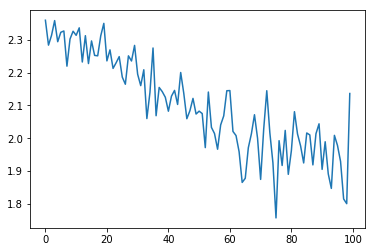

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

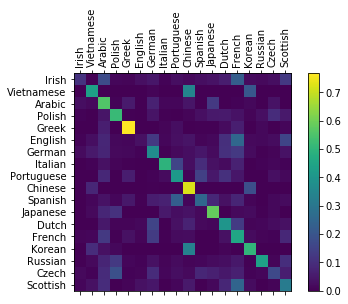

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [43]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.01) Polish
(-1.77) Russian
(-2.19) Czech

> Jackson
(-1.28) Scottish
(-1.83) Russian
(-2.22) English

> Satoshi
(-1.08) Polish
(-1.89) Italian
(-2.41) Czech
